In [2]:
import os
import tensorflow as tf
import numpy as np
import json
import random

SEED = 1234
tf.random.set_seed(SEED)

In [3]:
#Creation of data generator objects

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='constant',#when we flip, rotate, we introduce new pixels and we must set a way on how to fill
                                       cval=0,
                                       rescale=1/255.)

else:
    train_data_gen = ImageDataGenerator(rescale=1/255.)
    
valid_data_gen = ImageDataGenerator(rescale=1/255.)


In [4]:
#Setting paths for training, validation and test set

cwd = os.path.join(os.path.dirname(os.getcwd()),"artificial-neural-networks-and-deep-learning-2020/MaskDataset/")

dataset_dir = os.path.join(cwd, "training/")
validation_dir = os.path.join(cwd, "validation/")
test_dir = os.path.join(cwd, "test/")

In [5]:
path = os.getcwd()
print ("The current working directory is %s" % test_dir)

The current working directory is D:\Uni\Artificial Neural Networks and Deep Learning\Kaggle\artificial-neural-networks-and-deep-learning-2020/MaskDataset/test/


In [6]:
with open(os.path.join(cwd,'train_gt.json')) as f:
  myJson = json.load(f)
print(myJson)

{'14985.jpg': 0, '13358.jpg': 0, '10210.jpg': 0, '18202.jpg': 0, '14962.jpg': 0, '13243.jpg': 0, '11116.jpg': 0, '14251.jpg': 0, '15818.jpg': 0, '15552.jpg': 0, '16795.jpg': 0, '15952.jpg': 0, '11918.jpg': 0, '11657.jpg': 0, '11150.jpg': 0, '14006.jpg': 0, '11271.jpg': 0, '10935.jpg': 0, '16664.jpg': 0, '15919.jpg': 0, '14038.jpg': 0, '18138.jpg': 0, '13709.jpg': 0, '10410.jpg': 0, '11966.jpg': 0, '12230.jpg': 0, '16157.jpg': 0, '13944.jpg': 0, '17170.jpg': 0, '16603.jpg': 0, '16910.jpg': 0, '14724.jpg': 0, '13580.jpg': 0, '17098.jpg': 0, '10634.jpg': 0, '15741.jpg': 0, '11158.jpg': 0, '16290.jpg': 0, '16503.jpg': 0, '12982.jpg': 0, '12581.jpg': 0, '13975.jpg': 0, '13113.jpg': 0, '12834.jpg': 0, '18002.jpg': 0, '16344.jpg': 0, '12968.jpg': 0, '14342.jpg': 0, '13133.jpg': 0, '12859.jpg': 0, '15476.jpg': 0, '14589.jpg': 0, '13468.jpg': 0, '14427.jpg': 0, '13787.jpg': 0, '10603.jpg': 0, '18004.jpg': 0, '16903.jpg': 0, '15523.jpg': 0, '18030.jpg': 0, '12960.jpg': 0, '14212.jpg': 0, '10172.

In [7]:
#division of images in different set

for key in myJson:
    os.rename(os.path.join(dataset_dir,key), dataset_dir+'/'+str(myJson[key])+'/'+key)

FileNotFoundError: [WinError 2] Impossibile trovare il file specificato: 'D:\\Uni\\Artificial Neural Networks and Deep Learning\\Kaggle\\artificial-neural-networks-and-deep-learning-2020/MaskDataset/training/14985.jpg' -> 'D:\\Uni\\Artificial Neural Networks and Deep Learning\\Kaggle\\artificial-neural-networks-and-deep-learning-2020/MaskDataset/training//0/14985.jpg'

In [8]:
#reset validation set to empty set
for i in range(3):
    curr_dir = os.path.join(cwd, "validation/" + str(i))
    image_filenames = next(os.walk(curr_dir))[2]

    for image_name in image_filenames:
        os.rename(os.path.join(curr_dir,image_name), dataset_dir+'/'+str(myJson[image_name])+'/'+image_name)

In [9]:
#choose 5% random images from the training set and move them to validation set
random.seed(SEED)

for i in range(3):
    curr_dir = os.path.join(cwd, "training/" + str(i))
    image_filenames = next(os.walk(curr_dir))[2]

    for image_name in image_filenames:
        if 100*random.random() < 4:
            os.rename(os.path.join(curr_dir,image_name), validation_dir+'/'+str(myJson[image_name])+'/'+image_name)
    


In [18]:
#Generators for reading images dirrectly from directories

img_h = 408
img_w = 612

bs=8

#training generator
train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(img_h,img_w),
                                              color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)
#validation generator
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)


Found 5405 images belonging to 3 classes.
Found 209 images belonging to 3 classes.


In [19]:
#creation of dataset objects
num_classes = 3

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

train_dataset=train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

valid_dataset=valid_dataset.repeat()

In [20]:
import matplotlib.pyplot as plt

iterator = iter(train_dataset)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

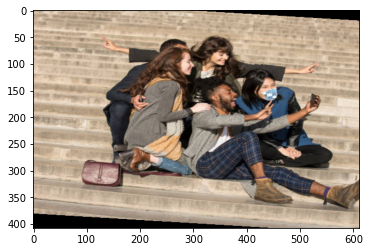

In [21]:
augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot

In [22]:
#Neural network structure

start_f = 12
depth = 5

model = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        input_shape = [img_h,img_w,3]
    else:
        input_shape = [None]
    
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='same',
                                    input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    
    #Add dropout after first layer
    if i == 0:
        model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    start_f *=2
    
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 408, 612, 12)      336       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 408, 612, 12)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 408, 612, 12)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 204, 306, 12)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 204, 306, 24)      2616      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 204, 306, 24)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 102, 153, 24)     

In [23]:
#Loss function
loss = tf.keras.losses.CategoricalCrossentropy()

#Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Validation metric used during training
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [24]:
#Callbacks list

from datetime import datetime

exps_dir = os.path.join(os.getcwd(),'weights')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name='FC'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

ckpt_dir = os.path.join(exp_dir,'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#Checkpoint callback
saveBestOnly = True
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'cp.ckpt'),save_weights_only=True)

callbacks.append(ckpt_callback)

#tensorboard callback
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
tb_callback=tf.keras.callbacks.TensorBoard(log_dir=tb_dir,histogram_freq=1)


# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(es_callback)



In [25]:
#model.load_weights(filepath=os.path.join(cwd,'cp.ckpt'))


model.fit(x=train_dataset,
         epochs=100,
         steps_per_epoch=len(train_gen),
        validation_data=valid_dataset,
         validation_steps=len(valid_gen),
         callbacks=callbacks)

Train for 676 steps, validate for 27 steps
Epoch 1/100
  1/676 [..............................] - ETA: 6:32:37

ResourceExhaustedError:  OOM when allocating tensor with shape[8,12,408,612] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/dropout_1/dropout/mul (defined at <ipython-input-25-f0bb8963fbe8>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_3081]

Function call stack:
distributed_function


In [125]:
#Save model

#model.save('my_model')

#Load weights
path = os.path.join(os.getcwd(), 'weights/salvati/6/cp.ckpt')

model.load_weights(path, by_name=False, skip_mismatch=False)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002282A520508> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002282A520BC8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002280EB180C8> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002280EAF8E48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002280EB15048> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002280EB21F48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002280EB183C8> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002280EB246C8>).


In [97]:
#Function for creating the result in a csv file

from datetime import datetime

def create_csv(results, results_dir='./results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')




In [98]:
#Prediction computation done one image at time

from PIL import Image

image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:
    
    image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    
    predictions = model.predict_classes(input_arr*(1/255))
    #img = Image.open(test_dir+'/'+image_name).convert('RGB')
    #img_array = np.array(img)
    #img_array = np.expand_dims(img_array, 0) 
    #data_normalization
    #print(np.argmax(predictions, axis=1)[0] )

    #prediction = argmax(softmax)   # predicted class
    

    #results[image_name] = np.argmax(predictions, axis=1) [0]
    
    results[image_name] = predictions[0]

create_csv(results)
print (results)

{'10001.jpg': 1, '10040.jpg': 2, '10074.jpg': 1, '10084.jpg': 1, '10100.jpg': 2, '10120.jpg': 1, '10125.jpg': 1, '10148.jpg': 1, '10213.jpg': 2, '10239.jpg': 1, '10242.jpg': 2, '10259.jpg': 1, '10289.jpg': 1, '10296.jpg': 0, '10323.jpg': 1, '10324.jpg': 0, '10326.jpg': 1, '10328.jpg': 0, '10330.jpg': 0, '10346.jpg': 0, '10349.jpg': 1, '10370.jpg': 1, '10382.jpg': 1, '10396.jpg': 1, '10411.jpg': 1, '10437.jpg': 1, '10459.jpg': 2, '10473.jpg': 1, '10477.jpg': 1, '10494.jpg': 0, '10520.jpg': 2, '10530.jpg': 1, '10571.jpg': 1, '10572.jpg': 1, '10581.jpg': 2, '10620.jpg': 0, '10641.jpg': 1, '10643.jpg': 1, '10662.jpg': 0, '10691.jpg': 1, '10715.jpg': 1, '10727.jpg': 1, '10760.jpg': 0, '10771.jpg': 1, '10782.jpg': 2, '10800.jpg': 2, '10812.jpg': 1, '10845.jpg': 0, '10850.jpg': 2, '10853.jpg': 2, '10863.jpg': 2, '10873.jpg': 0, '10999.jpg': 1, '11012.jpg': 1, '11026.jpg': 0, '11045.jpg': 1, '11115.jpg': 0, '11130.jpg': 1, '11136.jpg': 1, '11137.jpg': 1, '11175.jpg': 0, '11176.jpg': 1, '11202.

In [51]:
model.save_weights(filepath=os.path.join(cwd,'cp.ckpt'))

In [52]:
csv_fname = 'results_'
csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'
results_dir='/results'
(os.path.join(os.getcwd(), csv_fname)
print(os.path.join(results_dir, csv_fname))

SyntaxError: invalid syntax (<ipython-input-52-e5d608a92abf>, line 5)

(1, 408, 612, 3)
[[[[0.06666667 0.03529412 0.02352941]
   [0.06666667 0.03529412 0.02352941]
   [0.07058824 0.04313726 0.01960784]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.06666667 0.03529412 0.02352941]
   [0.06666667 0.03921569 0.01568628]
   [0.07058824 0.04313726 0.01960784]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.06666667 0.03529412 0.02352941]
   [0.07058824 0.04313726 0.01960784]
   [0.07450981 0.04705882 0.02352941]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  ...

  [[0.00392157 0.00392157 0.        ]
   [0.00392157 0.00392157 0.        ]
   [0.00392157 0.00392157 0.        ]
   ...
   [0.20784314 0.06666667 0.00392157]
   [0.20784314 0.06666667 0.00392157]
   [0.20392157 0.0627451  0.        ]]

  [[0.00392157 0.00392157 0.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

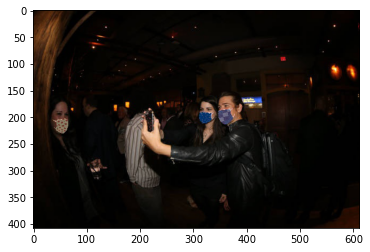

In [53]:
image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])*1/255
print(input_arr.shape)

#augmented_img = augmented_img * 255
print (input_arr)

plt.imshow(np.uint8(input_arr*255)[0])
plt.plot